In [1]:
%config InlineBackend.figure_format = "svg"

# from src.networks.qbn import QuantumBayesianNetwork
from src.networks.bn import BayesianNetwork
from src.networks.nodes import DiscreteNode

# Bayesian Network Class

## Create Bayesian Network Structure

Using the `BayesianNetwork` class defined in the `bn.py` file, we can define its structure by defining its nodes and edges. Its nodes should be defined using the `DiscreteNode` class, if one wishes to represent discrete random variables.

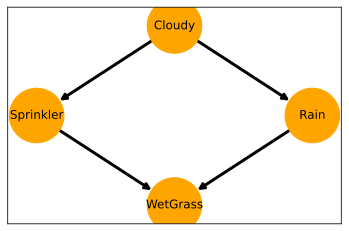

In [2]:
# Create the nodes
cloudy = DiscreteNode("Cloudy", "state", value_space=[0, 1])
sprinkler = DiscreteNode("Sprinkler", "state", value_space=[0, 1])
rain = DiscreteNode("Rain", "state", value_space=[0, 1])
wetgrass = DiscreteNode("WetGrass", "state", value_space=[0, 1])

# Create the Bayesian Network
bn = BayesianNetwork()
bn.add_nodes([cloudy, sprinkler, rain, wetgrass])
bn.add_edges([("Cloudy", "Sprinkler"), ("Cloudy", "Rain"), ("Sprinkler", "WetGrass"), ("Rain", "WetGrass")])
bn.draw()

## Populate Bayesian Network with data

However, the above code only gives the `BayesianNetwork` its structure! We also need to feed it the Conditional Probability Tables (CPTs) for each node. This can be done by creating a dictionary that represents each CPT:

In [3]:
# Add data for node cloudy
data = {"Cloudy": [0,1], "Prob": [0.5,0.5]}
bn.add_pt("Cloudy", data)

# Add data for node Sprinkler
data = {"Cloudy": [0,0,1,1], "Sprinkler": [0,1,0,1], "Prob": [0.5,0.5,0.9,0.1]}
bn.add_pt("Sprinkler", data)

# Add data for node Cloudy
data = {"Cloudy": [0,0,1,1], "Rain": [0,1,0,1], "Prob": [0.8,0.2,0.2,0.8]}
bn.add_pt("Rain", data)

# Add data for node WetGrass
data = {"Sprinkler": [0,0,0,0,1,1,1,1], "Rain": [0,0,1,1,0,0,1,1], "WetGrass": [0,1,0,1,0,1,0,1], "Prob": [1,0,0.1,0.9,0.1,0.9,0.01,0.99]}
bn.add_pt("WetGrass", data)

## Apply sampling and get results

Given that the network has been fully define, we can initialize it with the `initialize` method. This method lets the `BayesianNetwork` class define the correct node traversal order for performing inference.

In [4]:
# Initialize the network
bn.initialize()

Finally, since we already fully defined the `BayesianNetwork`, we can start querying it for any distribution we like! The line bellow represents one possible query and uses the `rejection sampling` algorithm to perform inference:

In [5]:
bn.query(query=["Cloudy", "Rain", "Sprinkler", "WetGrass"], n_samples=1000)

,Cloudy,Rain,Sprinkler,WetGrass,Prob
0,0.0,0.0,0.0,0.0,0.192
1,0.0,0.0,1.0,0.0,0.019
2,0.0,0.0,1.0,1.0,0.197
3,0.0,1.0,0.0,0.0,0.004
4,0.0,1.0,0.0,1.0,0.040
5,0.0,1.0,1.0,0.0,0.001
6,0.0,1.0,1.0,1.0,0.051
7,1.0,0.0,0.0,0.0,0.094
8,1.0,0.0,1.0,1.0,0.007
9,1.0,1.0,0.0,0.0,0.038


In [6]:
# Query the Bayesian Network
bn.query(query=["Cloudy", "WetGrass"], evidence={"Rain": 1, "Sprinkler": 0}, n_samples=1000)

,Cloudy,WetGrass,Prob
0,0.0,0.0,0.012
1,0.0,1.0,0.102
2,1.0,0.0,0.090
3,1.0,1.0,0.796


## Quantum Bayesian Networks

This first section's purpose is to represent the full joint distribution of the above bayesian network in a quantum circuit, so that we can get samples from the joint distribution just by performing measurements in the circuit.

A joint distribution in a BN with random variables $\mathcal{X} = \{X_1, \dots, X_n\}$ taking values $x_1, \dots, x_n$ can be mathematically described by the following equation:

$$ \mathbb{P} \left[ x_1, \dots, x_n \right] = \prod_{i=1}^{n} \mathbb{P} \left[ x_i \vert \text{parents}(x_i) \right] $$

By translating this equation to the example above, we get:

$$ \mathbb{P} \left[ c, r, s, w \right] = \mathbb{P} \left[ c \right] \mathbb{P} \left[ r \vert c \right] \mathbb{P} \left[ s \vert c \right] \mathbb{P} \left[ w \vert r, s \right] $$

In a general case, translating a BN into a quantum circuit involves applying a controlled rotation gate $\hat{U}_i$ on the target qubit of the random variable $X_i$, controlled by the qubits of the random variables that are parents of the target qubit, $\text{parents}(X_i)$, for each combination of values the parents random variables can take. This ensures we encode every entry of the CPTs in the BN into the quantum circuit.

Let's consider an example. For the WetGrass node in the BN above, we will need to apply 4 of these rotation gates, since this node has two parents and each of them can take two possible values. 

Say we want to encode a controlled rotation for WetGrass $w$ when $s = 1$ and $r = 0$. To do so, we want to apply that rotation when $\vert s \rangle = \vert 1 \rangle$ and $\vert r \rangle = \vert 0 \rangle$.

This gate should perform a controlled $RY(\theta_i)$ rotation about the y-axis. Suppose $P_i = \{P_{i1}, \dots, P_{im}\}$ are the parent random variables of the random variable $X_i$ and that we are considering a rotation where they take the values $p_{i1}, \dots, p_{im}$. The angle $\theta_i$ is given by the expression:

$$ \theta_i = 2 \arctan \left( \sqrt{ \frac{ \mathbb{P} \left[ X_i = 1 \vert P_{i1} = p_{i1}, \dots, P_{im} = p_{im} \right] }{ \mathbb{P} \left[ X_i = 0 \vert P_{i1} = p_{i1}, \dots, P_{im} = p_{im} \right] } } \right) $$

This is all implemented in the `qbn.py` file. The way the Quantum Bayesian Network class is defined requires it to be initiallized with our classical Bayesian Network class, which we should pass as an argument to the class.

In [7]:
# Create the Quantum Bayesian Network
# qbn = QuantumBayesianNetwork(bn)

Now we can finally perform inference on the QBN by simply calling its `query` method.

Let's start by getting the joint distribution.

In [8]:
# qbn.query(query=["Cloudy", "Rain", "Sprinkler", "WetGrass"], n_samples=1000)

And as we can see, it is very similar to the one obtained above. 

Similarly, let's ask for a conditional distribution and compare with the classical example to verify that they are also identical.

In [9]:
# qbn.query(query=["Cloudy", "WetGrass"], evidence={"Rain": 1, "Sprinkler": 0}, n_samples=1000)